# LSTM baseline

from kuto

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [2]:
import os
import sys
import glob
import pickle
import random

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path


In [4]:
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [5]:
import pytorch_lightning as pl
# from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping

import wandb
from pytorch_lightning.loggers import WandbLogger

In [6]:
sys.path.append('../../')
import src.utils as utils

In [7]:
import multiprocessing
import scipy.interpolate
import scipy.sparse
from tqdm import tqdm

from indoor_location_competition_20.io_f import read_data_file
import indoor_location_competition_20.compute_f as compute_f

In [8]:
DATA_DIR = Path("/home/knikaido/work/Indoor-Location-Navigation/data/")
WIFI_DIR = DATA_DIR / 'indoorunifiedwifids_original'
MLFLOW_DIR = DATA_DIR / 'mlflow/mlruns'
OUTPUT_DIR = Path('./output/')
MLFLOW_DIR = DATA_DIR / 'mlflow/mlruns'

## config

In [9]:
configs = {
    'loss':{
        'name': 'MSELoss',
        'params':{}
    },
    'optimizer':{
        'name': 'Adam',
        'params':{
            'lr': 0.01,
        }
    },

    'scheduler':{
        'name': 'ReduceLROnPlateau',
        'params':{
            'factor': 0.1,
            'patience': 3,
        }
    },

    'loader':{
        'train':{
            'batch_size': 512,
            'shuffle': True,
            'num_workers': 4,
        },
        'valid':{
            'batch_size': 512,
            'shuffle': False,
            'num_workers': 4,
        },
        'test':{
            'batch_size': 512,
            'shuffle': False,
            'num_workers': 4,
        }
    }
}

In [10]:
# config
config = configs

# globals variable
SEED = 777
MAX_EPOCHS = 500
N_SPLITS = 5
DEBUG = False
# EXP_MESSAGE = config['globals']['exp_message']

EXP_NAME = 40
IS_SAVE = True

utils.set_seed(SEED)

In [11]:
!wandb login e8aaf98060af90035c3c28a83b34452780aeec20

/bin/sh: 1: wandb: not found


## read data

In [12]:
train_df = pd.read_csv(WIFI_DIR / 'train_10_th10000_200.csv')
test_df = pd.read_csv(WIFI_DIR / 'test_10_th10000.csv')

In [13]:
sub = pd.read_csv(DATA_DIR/'indoor-location-navigation/sample_submission.csv', index_col=0)

BSSIDとRSSIは100ずつ存在しているけど全てが必要なわけではないみたい  
ここでは20だけ取り出している。

In [14]:
# training target features
NUM_FEATS = 80
BSSID_FEATS = [f'bssid_{i}' for i in range(NUM_FEATS)]
RSSI_FEATS  = [f'rssi_{i}' for i in range(NUM_FEATS)]

In [15]:
train_df.iloc[:, 100:110]

,bssid_0,bssid_1,bssid_2,bssid_3,bssid_4,bssid_5,bssid_6,bssid_7,bssid_8,bssid_9
0,e9b24f94c0007acb4b7169b945622efcd332cf6f,591ea59cf88e3397db5d60eb00a5147edd69399a,590a4dd2afa1ad07090fd5f390f65a55e3dc5f56,a77f8e93896f8fc8bc0d0700ca04b802ee79a07f,1b2fd184314ae440900fa9ce1addeb896b5604a9,2c09230bb32ee49f6a72928f6eeefb6885dc15ce,3799b46aa4cf6c3c45c0bc27d8f1efefea96914f,fc6956beb062b5158252c66953e92a0d25495cac,c71a2f5c4282d27f84b9b841db0e310ef0fcf6cd,4f8b7c168dc76c9d3b4ca7903042173e98fe2ddb
1,e9b24f94c0007acb4b7169b945622efcd332cf6f,590a4dd2afa1ad07090fd5f390f65a55e3dc5f56,591ea59cf88e3397db5d60eb00a5147edd69399a,d32dd11040b254cd889c9ead2d4a50f6e3900196,9c832009dfb1ee02053c9ce9b7770b6cd3191003,509d1f842b0773e85c6beec0bb530542efd35cb9,1b2fd184314ae440900fa9ce1addeb896b5604a9,f920a2e4cb52165850990d9d37d391b630f7de14,6a42281c99a4cff2ce9dba3fc91ad6a431af64d9,fc6956beb062b5158252c66953e92a0d25495cac
2,590a4dd2afa1ad07090fd5f390f65a55e3dc5f56,e9b24f94c0007acb4b7169b945622efcd332cf6f,591ea59cf88e3397db5d60eb00a5147edd69399a,509d1f842b0773e85c6beec0bb530542efd35cb9,b2337b25e7d1df04928bf6698a9c0b2764df7795,76f81d5047273fa64a434457531d400fc5d90fac,6e388d1db5ba8dd9de80522a4ddf50402cf443b3,8c6ab78f2797e076f9106af81090d0ab9904f5cd,ceccac4f0e50ec9e36e8d2800b8f2c7c3b4d903e,f920a2e4cb52165850990d9d37d391b630f7de14
3,db62fcdb99bb797d06771103f8536ff903de438e,a367e4b58bbc0b6630cfe725260de764422afe1e,78263f1b65e22aed4750fe3690f95ec60193ef72,f4ee0c2d3b9049781fbdfb0012dfcbac151f67f6,780362b9f634fdd22d4303561a2f75a4bbe4c2ef,8a6cadd8c33318a20f36845668a18a8eaf6120ae,fb43bce78d303baa0b55a50e5482cc8b6b0469a0,5aec0872dd4f43d0eaa0c2ee05f1a1b546f3f768,66980cd9d4c9563e6bf94802c5195c4b56cef7a1,80e0e21ba06136f3b168295fea79ede3a7b43f12
4,590a4dd2afa1ad07090fd5f390f65a55e3dc5f56,591ea59cf88e3397db5d60eb00a5147edd69399a,e9b24f94c0007acb4b7169b945622efcd332cf6f,6ec56c3efdeb067eb20bd2f4a6ccdae07d640cc1,d32dd11040b254cd889c9ead2d4a50f6e3900196,f920a2e4cb52165850990d9d37d391b630f7de14,6a42281c99a4cff2ce9dba3fc91ad6a431af64d9,9c832009dfb1ee02053c9ce9b7770b6cd3191003,509d1f842b0773e85c6beec0bb530542efd35cb9,0452e85d0a41780463cfe079077ea5bd2f519c7a
...,...,...,...,...,...,...,...,...,...,...
301841,5964a27e0cb3344b0a18540e6b3120c433971c38,d090a2f7f222fadeeb64e4fbdfe1ca8451116b04,cce41299a022ada08aebf3d309acb07d5f00b014,346b34a42e801c64e043dbaacbe7fef9b8880774,4b5dbdb52b131410ea10b59ea451de62280b41d6,fa11fc4d4960379cb68cc6968ba6415168fef53c,5f583dcccc43b5b7ac25d270e29c92d878fb2be0,4d2e5639041b40b0df2ee258aa504bd904133d80,dfc21edb1f7650d5645fd672bbe6a13fc6fd77f8,a94eb920c0a198fe8385f3de6a8e8e6d44b6f6c9
301842,5964a27e0cb3344b0a18540e6b3120c433971c38,346b34a42e801c64e043dbaacbe7fef9b8880774,d090a2f7f222fadeeb64e4fbdfe1ca8451116b04,cce41299a022ada08aebf3d309acb07d5f00b014,566e0c6e3bcf2b8b3d310d96f111043d17ace817,bd3fc24710537130e97dc2dab4a6bf70b3884a8b,4b5dbdb52b131410ea10b59ea451de62280b41d6,4d2e5639041b40b0df2ee258aa504bd904133d80,f4107af4418d57aacb3542343f7b47768debdc75,5f583dcccc43b5b7ac25d270e29c92d878fb2be0
301843,346b34a42e801c64e043dbaacbe7fef9b8880774,5964a27e0cb3344b0a18540e6b3120c433971c38,cce41299a022ada08aebf3d309acb07d5f00b014,566e0c6e3bcf2b8b3d310d96f111043d17ace817,bd3fc24710537130e97dc2dab4a6bf70b3884a8b,d090a2f7f222fadeeb64e4fbdfe1ca8451116b04,4b5dbdb52b131410ea10b59ea451de62280b41d6,a94eb920c0a198fe8385f3de6a8e8e6d44b6f6c9,ee5ca7a7deaacdcd5d99355ff5f156dc45b74efa,a7986c0cea5d2571ea42011ab4407039e977c0bd
301844,346b34a42e801c64e043dbaacbe7fef9b8880774,d090a2f7f222fadeeb64e4fbdfe1ca8451116b04,5964a27e0cb3344b0a18540e6b3120c433971c38,f4107af4418d57aacb3542343f7b47768debdc75,cce41299a022ada08aebf3d309acb07d5f00b014,4b5dbdb52b131410ea10b59ea451de62280b41d6,fa11fc4d4960379cb68cc6968ba6415168fef53c,a7986c0cea5d2571ea42011ab4407039e977c0bd,180a351ec58c07d60949862c534373c43f548a9a,4d2e5639041b40b0df2ee258aa504bd904133d80


bssid_NはN個目のBSSIDを示しておりRSSI値が大きい順に番号が振られている。
100個しかない


In [16]:
# get numbers of bssids to embed them in a layer

# train
wifi_bssids = []
# bssidを列ごとにリストに入れていく
for i in range(100, 200):
    wifi_bssids.extend(train_df.iloc[:,i].values.tolist())
wifi_bssids = list(set(wifi_bssids))

train_wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES(train): {train_wifi_bssids_size}')

# test
wifi_bssids_test = []
for i in range(100, 200):
    wifi_bssids_test.extend(test_df.iloc[:,i].values.tolist())
wifi_bssids_test = list(set(wifi_bssids_test))

test_wifi_bssids_size = len(wifi_bssids_test)
print(f'BSSID TYPES(test): {test_wifi_bssids_size}')


wifi_bssids.extend(wifi_bssids_test)
wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES(all): {wifi_bssids_size}')


BSSID TYPES(train): 62537
BSSID TYPES(test): 31133
BSSID TYPES(all): 93670


In [17]:
# get numbers of bssids to embed them in a layer

# train
rssi_bssids = []
# bssidを列ごとにリストに入れていく
for i in RSSI_FEATS:
    rssi_bssids.extend(train_df.loc[:,i].values.tolist())
rssi_bssids = list(set(rssi_bssids))

train_rssi_bssids_size = len(rssi_bssids)
print(f'RSSI TYPES(train): {train_rssi_bssids_size}')

# test
rssi_bssids_test = []
for i in RSSI_FEATS:
    rssi_bssids_test.extend(test_df.loc[:,i].values.tolist())
rssi_bssids_test = list(set(rssi_bssids_test))

test_rssi_bssids_size = len(rssi_bssids_test)
print(f'RSSI TYPES(test): {test_rssi_bssids_size}')


rssi_bssids.extend(rssi_bssids_test)
rssi_bssids_size = len(rssi_bssids)
print(f'RSSI TYPES(all): {rssi_bssids_size}')

RSSI TYPES(train): 97
RSSI TYPES(test): 77
RSSI TYPES(all): 174


## PreProcess

In [18]:
# preprocess

le = LabelEncoder()
le.fit(wifi_bssids)
le_site = LabelEncoder()
le_site.fit(train_df['site_id'])
le_rssi = LabelEncoder()
le_rssi.fit(rssi_bssids)

ss = StandardScaler()
ss.fit(train_df.loc[:,RSSI_FEATS])


def preprocess(input_df, le=le, le_site=le_site, ss=ss):
    output_df = input_df.copy()
    # RSSIの正規化
#     output_df.loc[:,RSSI_FEATS] = ss.transform(input_df.loc[:,RSSI_FEATS])

    # BSSIDのLE(1からふる)
    for i in BSSID_FEATS:
        output_df.loc[:,i] = le.transform(input_df.loc[:,i])
#         output_df.loc[:,i] = output_df.loc[:,i] + 1  # 0からではなく1から番号を振りたいため なぜ？
    for i in RSSI_FEATS:
        output_df.loc[:,i] = le_rssi.transform(input_df.loc[:,i])

    # site_idのLE
    output_df.loc[:, 'site_id'] = le_site.transform(input_df.loc[:, 'site_id'])

    # なぜ２重でやる？
#     output_df.loc[:,RSSI_FEATS] = ss.transform(output_df.loc[:,RSSI_FEATS])
    return output_df

train = preprocess(train_df)
test = preprocess(test_df)

train  

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


,ssid_0,ssid_1,ssid_2,ssid_3,ssid_4,ssid_5,ssid_6,ssid_7,ssid_8,ssid_9,...,frequency_97,frequency_98,frequency_99,wp_tmestamp,x,y,floor,floor_str,path_id,site_id
0,b7e6027447eb1f81327d66cfd3adbe557aabf26c,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,7182afc4e5c212133d5d7d76eb3df6c24618302b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,8c1562bec17e1425615f3402f72dded3caa42ce5,b7e6027447eb1f81327d66cfd3adbe557aabf26c,da39a3ee5e6b4b0d3255bfef95601890afd80709,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,...,2452,2412,5745,1578469851129,157.99141,102.12539,-1.0,B1,5e158ef61506f2000638fd1f,0
1,b7e6027447eb1f81327d66cfd3adbe557aabf26c,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,7182afc4e5c212133d5d7d76eb3df6c24618302b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,b7e6027447eb1f81327d66cfd3adbe557aabf26c,...,5745,5765,5765,1578469857653,162.93443,106.41302,-1.0,B1,5e158ef61506f2000638fd1f,0
2,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,...,5825,5765,5745,1578469857653,162.93443,106.41302,-1.0,B1,5e158ef61506f2000638fd1f,0
3,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,...,5805,2452,2412,1578469857653,162.93443,106.41302,-1.0,B1,5e158ef61506f2000638fd1f,0
4,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,b7e6027447eb1f81327d66cfd3adbe557aabf26c,da39a3ee5e6b4b0d3255bfef95601890afd80709,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,...,5180,5180,5825,1578469857653,162.93443,106.41302,-1.0,B1,5e158ef61506f2000638fd1f,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301841,ea7731d04cf9ed352d4805b1ff904bebdf60eb49,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,4abd3985ba804364272767c04cdc211615f77c56,b5d43f6b4e1938ed497c7b589c6eae9ac0bee168,0a8a55cf161bc4980194ec9f7f7a448439be4b74,1f09251bbfadafb11c63c87963af25238d6bc886,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,da39a3ee5e6b4b0d3255bfef95601890afd80709,1556355684145fce5e67ba749d943a180266ad90,...,0,0,0,1573733061352,203.53165,143.51396,6.0,F7,5dcd5c9323759900063d590a,23
301842,ea7731d04cf9ed352d4805b1ff904bebdf60eb49,4abd3985ba804364272767c04cdc211615f77c56,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,b5d43f6b4e1938ed497c7b589c6eae9ac0bee168,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,4abd3985ba804364272767c04cdc211615f77c56,1f09251bbfadafb11c63c87963af25238d6bc886,...,0,0,0,1573733070079,192.57130,145.78145,6.0,F7,5dcd5c9323759900063d590a,23
301843,4abd3985ba804364272767c04cdc211615f77c56,ea7731d04cf9ed352d4805b1ff904bebdf60eb49,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,1556355684145fce5e67ba749d943a180266ad90,b5d43

In [19]:
site_count = len(train['site_id'].unique())
site_count

24

## PyTorch model
- embedding layerが重要  

In [20]:
# dataset
from torch.utils.data import Dataset, DataLoader
class IndoorDataset(Dataset):
    def __init__(self, df, phase='train'):
        self.df = df
        self.phase = phase
        self.bssid_feats = df[BSSID_FEATS].values.astype(int)
        self.rssi_feats = df[RSSI_FEATS].values.astype(int)
        self.site_id = df['site_id'].values.astype(int)

        if phase in ['train', 'valid']:
            self.xy = df[['x', 'y']].values.astype(np.float32)
            self.floor = df['floor'].values.astype(np.float32)
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        
        concat_feat = np.empty(2 * NUM_FEATS).astype(int)
        concat_feat[0::2] = self.bssid_feats[idx]
        concat_feat[1::2] = self.rssi_feats[idx]
        
        feature = {
            'RSSI_BSSID_FEATS':concat_feat,
            'site_id':self.site_id[idx]
        }
        if self.phase in ['train', 'valid']:
            target = {
                'xy':self.xy[idx],
                'floor':self.floor[idx]
            }
        else:
            target = {}
        return feature, target

In [21]:
import torch
from torch import nn

class LSTMModel(nn.Module):
    def __init__(self, bssid_size=94248, site_size=24, embedding_dim=64):
        super(LSTMModel, self).__init__()
        
        # bssid
        # ->64次元に圧縮後sequence化にする
        # wifi_bssids_sizeが辞書の数を表す
        self.bssid_embedding = nn.Embedding(bssid_size, 64, max_norm=True)
        # site
        # ->2次元に圧縮後sequence化する
        # site_countが辞書の数を表す       
        self.site_embedding = nn.Embedding(site_size, 64, max_norm=True)

        # rssi
        # 次元を64倍に線形変換
#         self.rssi_embedding = nn.Embedding(rssi_size, 64, max_norm=True)
#         self.rssi = nn.Sequential(
#             nn.BatchNorm1d(NUM_FEATS),
#             nn.Linear(NUM_FEATS, NUM_FEATS * 64)
#         )
        
        concat_size = 64 + (2 * NUM_FEATS * 64)
        self.linear_layer2 = nn.Sequential(
            nn.BatchNorm1d(concat_size),
            nn.Dropout(0.3),
            nn.Linear(concat_size, 256),
            nn.ReLU()
        )
        self.bn1 = nn.BatchNorm1d(concat_size)

        self.flatten = nn.Flatten()

        self.dropout1 = nn.Dropout(0.3)
        self.linear1 = nn.Linear(in_features=concat_size, out_features=256)#, bias=False)
        self.bn2 = nn.BatchNorm1d(256)

        self.batch_norm1 = nn.BatchNorm1d(1)
        self.lstm1 = nn.LSTM(input_size=256,hidden_size=128,dropout=0.3, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128,hidden_size=16,dropout=0.1, batch_first=True)

        self.fc_xy = nn.Linear(16, 2)
        # self.fc_x = nn.Linear(16, 1)
        # self.fc_y = nn.Linear(16, 1)
        self.fc_floor = nn.Linear(16, 1)

    
    def forward(self, x):
        # input embedding
        batch_size = x["site_id"].shape[0]
        x_bssid = self.bssid_embedding(x['RSSI_BSSID_FEATS'])
        x_bssid = self.flatten(x_bssid)
        
        x_site_id = self.site_embedding(x['site_id'])
        x_site_id = self.flatten(x_site_id)

#         x_rssi = self.rssi_embedding(x['RSSI_FEATS'])
#         x_rssi = self.flatten(x_rssi)

        x = torch.cat([x_bssid, x_site_id], dim=1)
        x = self.linear_layer2(x)

        # lstm layer
        x = x.view(batch_size, 1, -1)  # [batch, 1]->[batch, 1, 1]
        x = self.batch_norm1(x)
        x, _ = self.lstm1(x)
        x = torch.relu(x)
        x, _ = self.lstm2(x)
        x = torch.relu(x)

        # output [batch, 1, 1] -> [batch]
        # x_ = self.fc_x(x).view(-1)
        # y_ = self.fc_y(x).view(-1)
        xy = self.fc_xy(x).squeeze(1)
        floor = torch.relu(self.fc_floor(x)).view(-1)
        # return {"x":x_, "y":y_, "floor":floor} 
        return {"xy": xy, "floor": floor}

In [22]:
def mean_position_error(xhat, yhat, fhat, x, y, f):
    intermediate = np.sqrt(np.power(xhat-x, 2) + np.power(yhat-y, 2)) + 15 * np.abs(fhat-f)
    return intermediate.sum()/xhat.shape[0]

def to_np(input):
    return input.detach().cpu().numpy()

In [23]:
def get_optimizer(model: nn.Module, config: dict):
    optimizer_config = config["optimizer"]
    optimizer_name = optimizer_config.get("name")
    base_optimizer_name = optimizer_config.get("base_name")
    optimizer_params = optimizer_config['params']

    if hasattr(optim, optimizer_name):
        optimizer = optim.__getattribute__(optimizer_name)(model.parameters(), **optimizer_params)
        return optimizer
    else:
        base_optimizer = optim.__getattribute__(base_optimizer_name)
        optimizer = globals().get(optimizer_name)(
            model.parameters(), 
            base_optimizer,
            **optimizer_config["params"])
        return  optimizer

def get_scheduler(optimizer, config: dict):
    scheduler_config = config["scheduler"]
    scheduler_name = scheduler_config.get("name")

    if scheduler_name is None:
        return
    else:
        return optim.lr_scheduler.__getattribute__(scheduler_name)(
            optimizer, **scheduler_config["params"])


def get_criterion(config: dict):
    loss_config = config["loss"]
    loss_name = loss_config["name"]
    loss_params = {} if loss_config.get("params") is None else loss_config.get("params")
    if hasattr(nn, loss_name):
        criterion = nn.__getattribute__(loss_name)(**loss_params)
    else:
        criterion = globals().get(loss_name)(**loss_params)

    return criterion

def worker_init_fn(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)

In [24]:
# Learner class(pytorch-lighting)
class Learner(pl.LightningModule):
    def __init__(self, model, config):
        super().__init__()
        self.model = model
        self.config = config
        self.xy_criterion = get_criterion(config)
        self.f_criterion = get_criterion(config)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self.model(x)
        loss = self.xy_criterion(output["xy"], y["xy"])
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self.model(x)
        xy_loss = self.xy_criterion(output["xy"], y["xy"])
        f_loss = self.f_criterion(output["floor"], y["floor"])
        loss = xy_loss  # + f_loss
        mpe = mean_position_error(
            to_np(output['xy'][:, 0]), to_np(output['xy'][:, 1]), 0, 
            to_np(y['xy'][:, 0]), to_np(y['xy'][:, 1]), 0)
        
        # floor lossは現状は無視して良い
        self.log(f'Loss/val', loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'Loss/xy', xy_loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'Loss/floor', f_loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'MPE/val', mpe, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        return mpe
    
    def validation_epoch_end(self, outputs):
        avg_loss = np.mean(outputs)
        print(f'epoch = {self.current_epoch}, mpe_loss = {avg_loss}')

    def configure_optimizers(self):
        optimizer = get_optimizer(self.model, self.config)
        scheduler = get_scheduler(optimizer, self.config)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "Loss/val"}

In [25]:
# oof
def evaluate(model, loaders, phase):
    x_list = []
    y_list = []
    f_list = []
    with torch.no_grad():
        for batch in loaders[phase]:
            x, y = batch
            output = model(x)
            x_list.append(to_np(output['xy'][:, 0]))
            y_list.append(to_np(output['xy'][:, 1]))
            f_list.append(to_np(output['floor']))

    x_list = np.concatenate(x_list)
    y_list = np.concatenate(y_list)
    f_list = np.concatenate(f_list)
    return x_list, y_list, f_list

## train

In [26]:
oofs = np.zeros((len(train), 2), dtype = np.float32)  # 全てのoofをdfで格納する
predictions = []  # 全ての予測値をdfで格納する
val_scores = []
# skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
gkf = GroupKFold(n_splits=N_SPLITS)
# for fold, (trn_idx, val_idx) in enumerate(skf.split(train.loc[:, 'path'], train.loc[:, 'path'])):
for fold, (trn_idx, val_idx) in enumerate(gkf.split(train.loc[:, 'path_id'], groups=train.loc[:, 'path_id'])):

    # 指定したfoldのみループを回す

    print('=' * 20)
    print(f'Fold {fold}')
    print('=' * 20)

    # train/valid data
    trn_df = train.loc[trn_idx, BSSID_FEATS + RSSI_FEATS + ['site_id', 'x','y','floor']].reset_index(drop=True)
    val_df = train.loc[val_idx, BSSID_FEATS + RSSI_FEATS + ['site_id', 'x','y','floor']].reset_index(drop=True)

    # data loader
    loaders = {}
    loader_config = config["loader"]
    loaders["train"] = DataLoader(IndoorDataset(trn_df, phase="train"), **loader_config["train"], worker_init_fn=worker_init_fn) 
    loaders["valid"] = DataLoader(IndoorDataset(val_df, phase="valid"), **loader_config["valid"], worker_init_fn=worker_init_fn)
    loaders["test"] = DataLoader(IndoorDataset(test, phase="test"), **loader_config["test"], worker_init_fn=worker_init_fn)
    
    # model
    model = LSTMModel(wifi_bssids_size+rssi_bssids_size, site_count)
    model_name = model.__class__.__name__
    
    # loggers
    RUN_NAME = f'exp{str(EXP_NAME)}'
    wandb.init(project='Indoor_Location_Navigation', entity='sqrt4kaido', group=RUN_NAME, job_type=RUN_NAME + f'-fold-{fold}')
    wandb.run.name = RUN_NAME + f'-fold-{fold}'
    wandb_config = wandb.config
    wandb_config.model_name = model_name
    wandb.watch(model)
    
    
    loggers = []
    loggers.append(WandbLogger())

    learner = Learner(model, config)
    
    # callbacks
    callbacks = []
    checkpoint_callback = ModelCheckpoint(
        monitor=f'Loss/val',
        mode='min',
        dirpath=OUTPUT_DIR,
        verbose=False,
        filename=f'{model_name}-{learner.current_epoch}-{fold}')
    callbacks.append(checkpoint_callback)

    early_stop_callback = EarlyStopping(
        monitor='Loss/val',
        min_delta=0.00,
        patience=20,
        verbose=True,
        mode='min')
    callbacks.append(early_stop_callback)
    
    trainer = pl.Trainer(
        logger=loggers,
        callbacks=callbacks,
        max_epochs=MAX_EPOCHS,
        default_root_dir=OUTPUT_DIR,
        gpus=1,
        fast_dev_run=DEBUG,
        deterministic=True,
        benchmark=True,
#         precision=16,
#         progress_bar_refresh_rate=0  # vscodeの時progress barの動作が遅いので表示しない
        )


    trainer.fit(learner, train_dataloader=loaders['train'], val_dataloaders=loaders['valid'])

    #############
    # validation (to make oof)
    #############
    model.eval()
    oof_x, oof_y, oof_f = evaluate(model, loaders, phase="valid")
    oofs[val_idx, 0] = oof_x
    oofs[val_idx, 1] = oof_y

    
    val_score = mean_position_error(
        oof_x, oof_y, 0,
        val_df['x'].values, val_df['y'].values, 0)
    val_scores.append(val_score)
    print(f"fold {fold}: mean position error {val_score}")

    #############
    # inference
    #############
    preds_x, preds_y, preds_f = evaluate(model, loaders, phase="test")
    test_preds = pd.DataFrame(np.stack((preds_f, preds_x, preds_y))).T
    test_preds.columns = sub.columns
    test_preds["site_path_timestamp"] = test["site_path_timestamp"]
    test_preds["floor"] = test_preds["floor"].astype(int)
    predictions.append(test_preds)
    

Fold 0


/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
wandb: Currently logged in as: sqrt4kaido (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.5 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.130    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 130.1596450805664


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 116.35251898816553


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 89.76034319158848


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 80.40505462769137


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 78.64609679626345


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 78.63630717810244


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 56.845995794515346


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 52.07279492277851


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 50.04286148678721


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 39.591591266126485


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 31.023773717162236


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 24.87716816952248


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 20.998978053872225


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 17.95955670409752


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 15.7815535344791


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 14.2215059490874


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 13.361823512414


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 12.393851645774838


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 12.506225564882714


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 11.60144377153657


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 11.44011008794103


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 11.272961265157853


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 10.587555500726886


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 10.796205957924279


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 10.584009113438027


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 10.294440083012212


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 9.923634117591543


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 10.773415572410705


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 10.513768882328982


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 10.053957123075511


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 9.8660663602447


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 9.874089009355803


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 10.810115355894489


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 9.668467669814094


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 9.897274156462073


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 9.97153346087791


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 9.80713424405471


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 9.753521377202459


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 9.534872759227069


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 9.53807922071081


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 9.754717873843651


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 9.671331574494182


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 9.841128417775616


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 8.701690760995637


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 8.588313465769824


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 8.479185064237681


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 8.429499562804532


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 8.447294929950742


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 8.398034588695916


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 8.323004037395446


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 8.355530173056879


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 8.33937027609252


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 8.331374213141753


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 8.370008714660225


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 8.301950072950818


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 8.26260981062347


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 8.26390256917788


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 8.269728743571267


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 8.271432717704787


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 8.261438353552318


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 8.267540858790355


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 8.262586518652771


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 8.264249681203749


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 8.267200295739741


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 8.268812197324987


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 8.274265791794566


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 8.254806305492039


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 8.260288773393288


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 8.264959837763042


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 8.273925196936306
fold 0: mean position error 8.274128290946004
Fold 1


/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Loss/val,65.27848
Loss/xy,65.27848
Loss/floor,4.63224
MPE/val,8.27413
epoch,68
trainer/global_step,32567
_runtime,363
_timestamp,1618983005
_step,68


Loss/val,█▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,▁▁▁▅▇▇▇▇▇▇██████████████████████████████
MPE/val,█▆▆▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.5 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.130    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 141.93357849121094


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 118.4990196389667


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 91.62729730875478


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 80.8187743415158


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 78.23801895160373


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 61.0362902603928


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 54.86265417912064


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 46.962982933704204


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 42.62634548147628


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 39.96490344552801


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 35.23041059733176


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 28.9199877228484


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 24.17763732802744


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 19.794873320133018


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 17.140119195701384


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 14.842590763018347


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 13.424159835930489


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 12.632420813748372


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 11.900925491702171


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 11.800638940379075


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 11.302893770251613


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 11.055984824112645


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 11.381159052467313


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 10.366781665015703


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 10.378136425642273


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 10.04126155469855


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 10.03825798118095


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 9.86944541014325


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 9.950453255661897


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 9.749159695842737


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 9.559080421092494


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 9.871225930450827


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 10.195784106905482


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 9.645784888650761


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 9.732573761513308


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 9.642738642613486


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 9.561274133807045


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 9.42072334213945


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 10.12731091543823


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 12.893205265384434


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 9.281897136581515


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 9.27741093913649


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 8.492916899081981


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 8.377722149041261


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 8.307224789607801


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 8.287841389108403


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 8.251247380013151


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 8.24055652071788


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 8.226753671446936


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 8.214345152216877


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 8.244638117662822


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 8.189897628922877


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 8.179757571103078


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 8.174252405891398


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 8.161020533322029


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 8.162039337823881


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 8.154738363481858


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 8.16673903549567


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 8.156584072043515


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 8.149990866799943


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 8.151651468688899


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 8.158356828109063


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 8.147346738415902


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 8.143693161566922


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 8.14839150037013


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 8.14518624262795


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 8.14091986469695


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 8.133306624404021


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 8.144224649877394


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 8.131171312179204


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 8.132880509501494


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 8.14576492553768


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 8.131689323917513


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 8.132297355593805


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 8.132088818618763


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 8.13278915143


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 8.14003110078812


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 8.136667153664533


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 8.13936070746708


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 8.132749388781493


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 8.136277983474105


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 8.137217464415736


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 8.135315010615857


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 8.134206405163072


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 8.128735499497601


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 8.133105962854799


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 8.135899028253181


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 8.140136755483928


Validating: 0it [00:00, ?it/s]

epoch = 87, mpe_loss = 8.134691880964638


Validating: 0it [00:00, ?it/s]

epoch = 88, mpe_loss = 8.135417777878873


Validating: 0it [00:00, ?it/s]

epoch = 89, mpe_loss = 8.134504025860608


Validating: 0it [00:00, ?it/s]

epoch = 90, mpe_loss = 8.131862625007706


Validating: 0it [00:00, ?it/s]

epoch = 91, mpe_loss = 8.130386728047238


Validating: 0it [00:00, ?it/s]

epoch = 92, mpe_loss = 8.137325673749022


Validating: 0it [00:00, ?it/s]

epoch = 93, mpe_loss = 8.13409888072159


Validating: 0it [00:00, ?it/s]

epoch = 94, mpe_loss = 8.137466224842825


Validating: 0it [00:00, ?it/s]

epoch = 95, mpe_loss = 8.131987813915172


Validating: 0it [00:00, ?it/s]

epoch = 96, mpe_loss = 8.128316613288227


Validating: 0it [00:00, ?it/s]

epoch = 97, mpe_loss = 8.131540591021107


Validating: 0it [00:00, ?it/s]

epoch = 98, mpe_loss = 8.134842007065028


Validating: 0it [00:00, ?it/s]

epoch = 99, mpe_loss = 8.132914871993082


Validating: 0it [00:00, ?it/s]

epoch = 100, mpe_loss = 8.13528287846555


Validating: 0it [00:00, ?it/s]

epoch = 101, mpe_loss = 8.135289185334365


Validating: 0it [00:00, ?it/s]

epoch = 102, mpe_loss = 8.138249428771505


Validating: 0it [00:00, ?it/s]

epoch = 103, mpe_loss = 8.13116563043026
fold 1: mean position error 8.131014779223664
Fold 2


Loss/val,54.93771
Loss/xy,54.93771
Loss/floor,4.84816
MPE/val,8.13101
epoch,103
trainer/global_step,49087
_runtime,550
_timestamp,1618983561
_step,103


Loss/val,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,▁▁▁▃▅▆▇▇▇███████████████████████████████
MPE/val,█▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.5 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.130    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 177.3797607421875


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 120.43719515886511


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 93.85402728560975


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 81.76145689974548


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 78.16246741816106


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 77.70916532130977


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 58.3997151320068


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 45.803923973134246


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 33.895705242289075


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 26.57667459162376


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 22.651018593431672


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 19.164679083512176


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 16.853343758470963


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 15.239265972090175


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 13.635427789964462


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 12.885068068479132


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 12.309541672236806


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 11.987793184139266


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 11.920651131812962


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 11.35964673540078


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 10.918440302043571


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 10.8683652444422


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 11.07134312736069


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 10.444585427469693


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 10.358461070056386


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 10.515155312896361


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 10.037829885931208


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 11.141257254847504


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 10.134195433293879


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 11.302309817782904


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 9.970638158322684


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 9.64792447462963


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 9.67963020730718


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 9.78741429087154


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 10.546448210260355


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 9.715281024004389


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 8.801260767448834


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 8.675247039876611


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 8.624659258806142


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 8.583639494830063


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 8.586202949310492


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 8.572299917812705


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 8.54740466078231


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 8.525534587282724


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 8.508554861970085


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 8.54297203899451


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 8.51131899735305


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 8.49684374323303


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 8.484182354138156


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 8.493696775500709


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 8.452130257081786


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 8.487620289364386


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 8.438209219406446


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 8.445266887714503


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 8.465829301753807


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 8.448541739331539


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 8.44569833406838


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 8.39120692300388


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 8.382012419068836


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 8.384609727718713


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 8.379073880082471


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 8.376266275721862


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 8.372118502069915


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 8.386899499430864


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 8.380047800242412


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 8.390006622382584


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 8.382492552686523


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 8.375430620913734


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 8.379472153082949


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 8.37714608166199


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 8.377796057167004


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 8.368528497668809


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 8.365030016498487


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 8.37279425760599


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 8.38327418157523


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 8.375669451882676


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 8.380071852683848


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 8.36919580825109


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 8.373678334779985


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 8.379594675882366


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 8.371866787616208


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 8.377306092074383


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 8.37729207212338


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 8.37601257121387


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 8.373488212296584


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 8.37532906741724


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 8.375756457022723


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 8.378828562007742


Validating: 0it [00:00, ?it/s]

epoch = 87, mpe_loss = 8.373018367611603


Validating: 0it [00:00, ?it/s]

epoch = 88, mpe_loss = 8.374338550760552


Validating: 0it [00:00, ?it/s]

epoch = 89, mpe_loss = 8.375210195328991


Validating: 0it [00:00, ?it/s]

epoch = 90, mpe_loss = 8.377371119140644


Validating: 0it [00:00, ?it/s]

epoch = 91, mpe_loss = 8.378945940258248
fold 2: mean position error 8.377892933592678
Fold 3


Loss/val,62.55003
Loss/xy,62.55003
Loss/floor,5.54133
MPE/val,8.37789
epoch,91
trainer/global_step,43423
_runtime,486
_timestamp,1618984053
_step,91


Loss/val,█▄▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▄▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,███▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
MPE/val,█▆▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.5 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.130    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 149.12862396240234


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 126.78212891605267


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 101.24404974677252


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 86.91874432182279


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 66.66470517112798


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 57.377443789862234


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 52.15714187856709


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 45.46598727572306


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 39.12096971152409


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 34.554013303061836


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 28.27552943695476


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 23.006917081975057


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 19.96507407199365


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 17.55264309617542


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 15.843459781193443


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 14.333756207446486


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 14.130450641641813


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 12.614363551952374


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 12.240081609244857


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 17.86444550987495


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 11.424869009512944


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 10.86001944341185


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 10.821243145289003


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 10.889378549867105


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 12.292003935596124


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 10.563120274216137


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 10.797683523582027


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 10.210595448038411


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 9.88849197728877


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 9.925972161154853


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 9.600470217090717


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 10.075806318155855


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 9.82679543261409


/home/user/.local/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


KeyboardInterrupt: 

In [27]:
oofs_df = pd.DataFrame(oofs, columns=['x', 'y'])
oofs_df['path'] = train_df['path_id']
oofs_df['timestamp'] = train_df['wp_tmestamp']
oofs_df['site'] = train_df['site_id']
oofs_df['site_path_timestamp'] = oofs_df['site'] + '_' + oofs_df['path'] + '_' + oofs_df['timestamp'].astype(str)
oofs_df['floor'] = train_df['floor']
oofs_df.to_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}.csv", index=False)
oofs_df

,x,y,path,timestamp,site,site_path_timestamp,floor
0,162.893433,104.692528,5e158ef61506f2000638fd1f,1578469851129,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
1,162.446518,106.405380,5e158ef61506f2000638fd1f,1578469857653,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
2,164.579666,112.362244,5e158ef61506f2000638fd1f,1578469857653,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
3,160.590393,107.649612,5e158ef61506f2000638fd1f,1578469857653,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
4,160.889114,113.969566,5e158ef61506f2000638fd1f,1578469862177,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
...,...,...,...,...,...,...,...
251108,193.860626,138.080200,5dcd5c9323759900063d590a,1573733061352,5dc8cea7659e181adb076a3f,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0
251109,191.472321,140.398544,5dcd5c9323759900063d590a,1573733070079,5dc8cea7659e181adb076a3f,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0
251110,190.818329,140.857559,5dcd5c9323759900063d590a,1573733070079,5dc8cea7659e181adb076a3f,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0
251111,188.174530,141.192642,5dcd5c9323759900063d590a,1573733070079,5dc8cea7659e181adb076a3f,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0


In [28]:
oofs_score = mean_position_error(
        oofs_df['x'], oofs_df['y'], 0,
        train_df['x'].values, train_df['y'].values, 0)
print(f"CV:{oofs_score}")

CV:7.2091618983083645


In [29]:
all_preds = pd.concat(predictions).groupby('site_path_timestamp').mean()
all_preds

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474563646,0,83.985733,104.124313
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474572654,0,82.191704,102.609261
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474578963,0,83.926353,105.360680
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474582400,0,87.992935,107.799019
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474585965,0,87.183846,108.356827
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731143256,0,211.220917,98.875908
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731146426,0,209.906998,101.332977
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731151563,0,206.155991,106.337158


In [36]:
all_preds_37 = pd.read_csv('../37/output/sub37.csv', index_col=0)
all_preds_37.index = pd.read_csv(WIFI_DIR / 'test_7_th20000.csv')['site_path_timestamp']
all_preds_37

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474563646,0,88.266884,104.794300
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474572654,0,82.316630,104.338745
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474578963,0,84.221380,105.362060
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474582400,0,87.842510,109.344190
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474585965,0,87.390120,108.134900
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731143256,5,214.121280,98.048190
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731146426,5,211.845250,100.757540
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731151563,5,208.958570,107.238950


In [38]:
all_preds_merge = pd.merge(all_preds_37, all_preds, how='left', on='site_path_timestamp')[['floor_y', 'x_y', 'y_y']]
all_preds_merge = all_preds_merge.rename(columns={'floor_y': 'floor', 'x_y': 'x', 'y_y': 'y'})
all_preds_merge

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474563646,0.0,83.985733,104.124313
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474572654,0.0,82.191704,102.609261
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474578963,0.0,83.926353,105.360680
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474582400,0.0,87.992935,107.799019
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474585965,0.0,87.183846,108.356827
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731143256,0.0,211.220917,98.875908
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731146426,0.0,209.906998,101.332977
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731151563,0.0,206.155991,106.337158


In [41]:
all_preds_merge['floor'].fillna(all_preds_37['floor'], inplace=True)
all_preds_merge['x'].fillna(all_preds_37['x'], inplace=True)
all_preds_merge['y'].fillna(all_preds_37['y'], inplace=True)
all_preds_merge

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474563646,0.0,83.985733,104.124313
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474572654,0.0,82.191704,102.609261
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474578963,0.0,83.926353,105.360680
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474582400,0.0,87.992935,107.799019
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474585965,0.0,87.183846,108.356827
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731143256,0.0,211.220917,98.875908
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731146426,0.0,209.906998,101.332977
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731151563,0.0,206.155991,106.337158


In [43]:
# foldの結果を平均した後、reindexでsubmission fileにindexを合わせる
all_preds_merge.index = sub.index
all_preds_merge

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0.0,83.985733,104.124313
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0.0,82.191704,102.609261
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0.0,83.926353,105.360680
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0.0,87.992935,107.799019
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0.0,87.183846,108.356827
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000082589,0.0,211.220917,98.875908
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000085758,0.0,209.906998,101.332977
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000090895,0.0,206.155991,106.337158


In [44]:
# floorの数値を置換
simple_accurate_99 = pd.read_csv('../01/submission.csv')
all_preds_merge['floor'] = simple_accurate_99['floor'].values
all_preds_merge.to_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}.csv")
all_preds_merge

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0,83.985733,104.124313
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0,82.191704,102.609261
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0,83.926353,105.360680
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0,87.992935,107.799019
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0,87.183846,108.356827
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000082589,5,211.220917,98.875908
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000085758,5,209.906998,101.332977
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000090895,5,206.155991,106.337158


# Post Proccess

In [45]:
oofs_df = pd.read_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}.csv")
sub_df = pd.read_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}.csv")

In [46]:
def compute_rel_positions(acce_datas, ahrs_datas):
    step_timestamps, step_indexs, step_acce_max_mins = compute_f.compute_steps(acce_datas)
    headings = compute_f.compute_headings(ahrs_datas)
    stride_lengths = compute_f.compute_stride_length(step_acce_max_mins)
    step_headings = compute_f.compute_step_heading(step_timestamps, headings)
    rel_positions = compute_f.compute_rel_positions(stride_lengths, step_headings)
    return rel_positions

In [47]:
def correct_path(args):

    path, path_df = args
    T_ref  = path_df['timestamp'].values
    xy_hat = path_df[['x', 'y']].values
    txt_path = path_df['txt_path'].values[0]
    
    example = read_data_file(txt_path)
    rel_positions = compute_rel_positions(example.acce, example.ahrs)
    if T_ref[-1] > rel_positions[-1, 0]:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)
    
    T_rel = rel_positions[:, 0]
    delta_xy_hat = np.diff(scipy.interpolate.interp1d(T_rel, np.cumsum(rel_positions[:, 1:3], axis=0), axis=0)(T_ref), axis=0)

    N = xy_hat.shape[0]
    delta_t = np.diff(T_ref)
    alpha = (8.1)**(-2) * np.ones(N)
    beta  = (0.3 + 0.3 * 1e-3 * delta_t)**(-2)
    A = scipy.sparse.spdiags(alpha, [0], N, N)
    B = scipy.sparse.spdiags( beta, [0], N-1, N-1)
    D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

    Q = A + (D.T @ B @ D)
    c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))
    xy_star = scipy.sparse.linalg.spsolve(Q, c)

    return pd.DataFrame({
        'site_path_timestamp' : path_df['site_path_timestamp'],
        'floor' : path_df['floor'],
        'x' : xy_star[:, 0],
        'y' : xy_star[:, 1],
    })

In [48]:
tmp = sub_df['site_path_timestamp'].apply(lambda s : pd.Series(s.split('_')))
sub_df['site'] = tmp[0]
sub_df['path'] = tmp[1]
sub_df['timestamp'] = tmp[2].astype(float)

In [49]:
used_buildings = sorted(sub_df['site'].value_counts().index.tolist())
test_txts = sorted(glob.glob(str(DATA_DIR/'indoor-location-navigation') + f'/test/*.txt'))
train_txts = [sorted(glob.glob(str(DATA_DIR/'indoor-location-navigation') + f'/train/{used_building}/*/*.txt')) for used_building in used_buildings]
train_txts = sum(train_txts, [])

In [50]:
txt_pathes = []
for path in tqdm(sub_df['path'].values):
    txt_pathes.append([test_txt for test_txt in test_txts if path in test_txt][0])

100%|██████████| 10133/10133 [00:00<00:00, 28839.26it/s]


In [51]:
sub_df['txt_path'] = txt_pathes

In [52]:
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(correct_path, sub_df.groupby('path'))
    dfs = tqdm(dfs)
    dfs = list(dfs)
sub_df_cm = pd.concat(dfs).sort_values('site_path_timestamp')

626it [01:07,  9.23it/s]


In [53]:
txt_pathes = []
for path in tqdm(oofs_df['path'].values):
    txt_pathes.append([train_txt for train_txt in train_txts if path in train_txt][0])

100%|██████████| 251113/251113 [02:25<00:00, 1728.95it/s]


In [54]:
oofs_df['txt_path'] = txt_pathes

In [55]:
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(correct_path, oofs_df.groupby('path'))
    dfs = tqdm(dfs)
    dfs = list(dfs)
oofs_df_cm = pd.concat(dfs).sort_index()
oofs_df_cm

10789it [07:59, 22.49it/s]


,site_path_timestamp,floor,x,y
0,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,159.198773,105.506443
1,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,162.188981,109.158696
2,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,162.183560,109.163590
3,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,162.174852,109.164095
4,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,165.652964,112.086506
...,...,...,...,...
251108,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0,202.287326,140.638727
251109,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0,187.153679,143.536941
251110,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0,187.160466,143.529373
251111,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0,187.162236,143.525470


In [56]:
oofs_df_cm.to_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_cm.csv", index=False)

In [57]:
oofs_score = mean_position_error(
        oofs_df_cm['x'], oofs_df_cm['y'], 0,
        train_df['x'].values, train_df['y'].values, 0)
print(f"CV:{oofs_score}")

CV:5.607853939328631


In [58]:
sub_df_cm.to_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}_cm.csv", index=False)

In [59]:
oofs_df_cm = pd.read_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_cm.csv")

In [60]:
sub_df_cm = pd.read_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}_cm.csv")

In [61]:
def split_col(df):
    df = pd.concat([
        df['site_path_timestamp'].str.split('_', expand=True) \
        .rename(columns={0:'site',
                         1:'path',
                         2:'timestamp'}),
        df
    ], axis=1).copy()
    return df
def sub_process(sub, train_waypoints):
    train_waypoints['isTrainWaypoint'] = True
    sub = split_col(sub[['site_path_timestamp','floor','x','y']]).copy()
    sub = sub.merge(train_waypoints[['site','floorNo','floor']].drop_duplicates(), how='left')
    sub = sub.merge(
        train_waypoints[['x','y','site','floor','isTrainWaypoint']].drop_duplicates(),
        how='left',
        on=['site','x','y','floor']
             )
    sub['isTrainWaypoint'] = sub['isTrainWaypoint'].fillna(False)
    return sub.copy()

In [62]:
train_waypoints = pd.read_csv(str(DATA_DIR/'indoor-location-navigation') + '/train_waypoints.csv')


In [63]:
sub_df_cm = sub_process(sub_df_cm, train_waypoints)
oofs_df_cm = sub_process(oofs_df_cm, train_waypoints)

In [64]:
from scipy.spatial.distance import cdist

def add_xy(df):
    df['xy'] = [(x, y) for x,y in zip(df['x'], df['y'])]
    return df

def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

sub_df_cm = add_xy(sub_df_cm)
train_waypoints = add_xy(train_waypoints)

ds = []
for (site, myfloor), d in tqdm(sub_df_cm.groupby(['site','floor'])):
    true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                          (train_waypoints['site'] == site)] \
        .reset_index(drop=True)
    if len(true_floor_locs) == 0:
        print(f'Skipping {site} {myfloor}')
        continue
    d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
    d['x_'] = d['matched_point'].apply(lambda x: x[0])
    d['y_'] = d['matched_point'].apply(lambda x: x[1])
    ds.append(d)

sub_df_cm_ds = pd.concat(ds)


oofs_df_cm = add_xy(oofs_df_cm)
train_waypoints = add_xy(train_waypoints)

ds = []
for (site, myfloor), d in tqdm(oofs_df_cm.groupby(['site','floor'])):
    true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                          (train_waypoints['site'] == site)] \
        .reset_index(drop=True)
    if len(true_floor_locs) == 0:
        print(f'Skipping {site} {myfloor}')
        continue
    d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
    d['x_'] = d['matched_point'].apply(lambda x: x[0])
    d['y_'] = d['matched_point'].apply(lambda x: x[1])
    ds.append(d)

oofs_df_cm_ds = pd.concat(ds)

  0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [65]:
def snap_to_grid(sub, threshold):
    """
    Snap to grid if within a threshold.
    
    x, y are the predicted points.
    x_, y_ are the closest grid points.
    _x_, _y_ are the new predictions after post processing.
    """
    sub['_x_'] = sub['x']
    sub['_y_'] = sub['y']
    sub.loc[sub['dist'] < threshold, '_x_'] = sub.loc[sub['dist'] < threshold]['x_']
    sub.loc[sub['dist'] < threshold, '_y_'] = sub.loc[sub['dist'] < threshold]['y_']
    return sub.copy()



In [66]:
# Calculate the distances
sub_df_cm_ds['dist'] = np.sqrt( (sub_df_cm_ds.x-sub_df_cm_ds.x_)**2 + (sub_df_cm_ds.y-sub_df_cm_ds.y_)**2 )
sub_pp = snap_to_grid(sub_df_cm_ds, threshold=5)
sub_pp = sub_pp[['site_path_timestamp','floor','_x_','_y_','site','path','floorNo']] \
    .rename(columns={'_x_':'x', '_y_':'y'})

# Calculate the distances
oofs_df_cm_ds['dist'] = np.sqrt( (oofs_df_cm_ds.x-oofs_df_cm_ds.x_)**2 + (oofs_df_cm_ds.y-oofs_df_cm_ds.y_)**2 )
oofs_pp = snap_to_grid(oofs_df_cm_ds, threshold=5)
oofs_pp = oofs_pp[['site_path_timestamp','floor','_x_','_y_','site','path','floorNo']] \
    .rename(columns={'_x_':'x', '_y_':'y'})

In [67]:
sub_pp = sub_pp.sort_index()
sub_pp

,site_path_timestamp,floor,x,y,site,path,floorNo
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,93.728470,97.948860,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,79.662285,102.766754,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,80.718400,107.197110,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,81.657740,110.509090,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,81.657740,110.509090,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
...,...,...,...,...,...,...,...
10128,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,206.627910,102.635210,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,F6
10129,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,206.627910,102.635210,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,F6
10130,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,206.334900,111.250860,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,F6
10131,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,195.958289,115.687827,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,F6


In [68]:
sub_pp[['site_path_timestamp','floor','x','y']] \
    .to_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}_pp.csv", index=False)

In [69]:
oofs_pp = oofs_pp.sort_index()
oofs_pp

,site_path_timestamp,floor,x,y,site,path,floorNo
0,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,158.49695,107.122680,5a0546857ecc773753327266,5e158ef61506f2000638fd1f,B1
1,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,162.33182,110.822685,5a0546857ecc773753327266,5e158ef61506f2000638fd1f,B1
2,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,162.33182,110.822685,5a0546857ecc773753327266,5e158ef61506f2000638fd1f,B1
3,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,162.33182,110.822685,5a0546857ecc773753327266,5e158ef61506f2000638fd1f,B1
4,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,162.33182,110.822685,5a0546857ecc773753327266,5e158ef61506f2000638fd1f,B1
...,...,...,...,...,...,...,...
251108,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0,202.50334,140.972670,5dc8cea7659e181adb076a3f,5dcd5c9323759900063d590a,F7
251109,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0,191.95721,143.862530,5dc8cea7659e181adb076a3f,5dcd5c9323759900063d590a,F7
251110,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0,191.95721,143.862530,5dc8cea7659e181adb076a3f,5dcd5c9323759900063d590a,F7
251111,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0,191.95721,143.862530,5dc8cea7659e181adb076a3f,5dcd5c9323759900063d590a,F7


In [70]:
oofs_score = mean_position_error(
        oofs_pp['x'], oofs_pp['y'], 0,
        train_df['x'].values, train_df['y'].values, 0)
print(f"CV:{oofs_score}")

CV:5.162855037455862


In [71]:
oofs_pp[['site_path_timestamp','floor','x','y']] \
    .to_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_pp.csv", index=False)

In [72]:
wandb.init(project='Indoor_Location_Navigation', entity='sqrt4kaido', group=RUN_NAME, job_type='summary')
wandb.run.name = 'summary'
wandb.log({'CV_score': oofs_score})
wandb.save(utils.get_notebook_path())
wandb.finish()

Loss/val,45.86727
Loss/xy,45.86727
Loss/floor,4.65394
MPE/val,7.31717
epoch,87
trainer/global_step,34583
_runtime,388
_timestamp,1618902907
_step,87


Loss/val,█▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,▇▇███▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MPE/val,█▅▄▄▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


CV_score,5.16286
_runtime,2
_timestamp,1618904865
_step,0


CV_score,▁
_runtime,▁
_timestamp,▁
_step,▁


In [73]:
import json
import matplotlib.pylab as plt

def plot_preds(
    site,
    floorNo,
    sub=None,
    true_locs=None,
    base=str(DATA_DIR/'indoor-location-navigation'),
    show_train=True,
    show_preds=True,
    fix_labels=True,
    map_floor=None
):
    """
    Plots predictions on floorplan map.
    
    map_floor : use a different floor's map
    """
    if map_floor is None:
        map_floor = floorNo
    # Prepare width_meter & height_meter (taken from the .json file)
    floor_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_image.png"
    json_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_info.json"
    with open(json_plan_filename) as json_file:
        json_data = json.load(json_file)

    width_meter = json_data["map_info"]["width"]
    height_meter = json_data["map_info"]["height"]

    floor_img = plt.imread(f"{base}/metadata/{site}/{map_floor}/floor_image.png")

    fig, ax = plt.subplots(figsize=(12, 12))
    plt.imshow(floor_img)

    if show_train:
        true_locs = true_locs.query('site == @site and floorNo == @map_floor').copy()
        true_locs["x_"] = true_locs["x"] * floor_img.shape[0] / height_meter
        true_locs["y_"] = (
            true_locs["y"] * -1 * floor_img.shape[1] / width_meter
        ) + floor_img.shape[0]
        true_locs.query("site == @site and floorNo == @map_floor").groupby("path").plot(
            x="x_",
            y="y_",
            style="+",
            ax=ax,
            label="train waypoint location",
            color="grey",
            alpha=0.5,
        )

    if show_preds:
        sub = sub.query('site == @site and floorNo == @floorNo').copy()
        sub["x_"] = sub["x"] * floor_img.shape[0] / height_meter
        sub["y_"] = (
            sub["y"] * -1 * floor_img.shape[1] / width_meter
        ) + floor_img.shape[0]
        for path, path_data in sub.query(
            "site == @site and floorNo == @floorNo"
        ).groupby("path"):
            path_data.plot(
                x="x_",
                y="y_",
                style=".-",
                ax=ax,
                title=f"{site} - floor - {floorNo}",
                alpha=1,
                label=path,
            )
    if fix_labels:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(
            by_label.values(), by_label.keys(), loc="center left", bbox_to_anchor=(1, 0.5)
        )
    return fig, ax

(<Figure size 864x864 with 1 Axes>,
 <AxesSubplot:title={'center':'5a0546857ecc773753327266 - floor - F1'}, xlabel='x_'>)

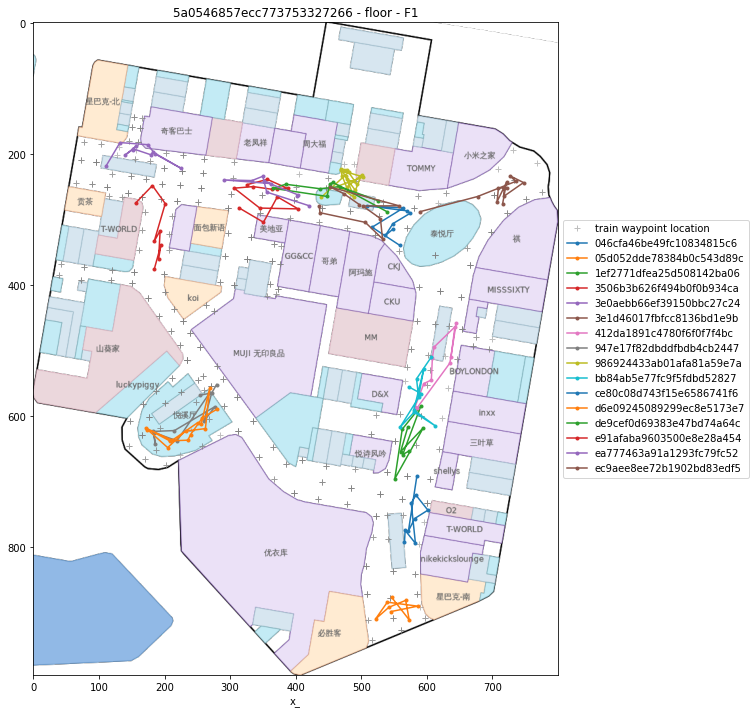

In [79]:
example_site = '5a0546857ecc773753327266'
example_floorNo = 'F1'

sub_df = sub_process(sub_df, train_waypoints)
plot_preds(example_site, example_floorNo, sub_df,
           train_waypoints, show_preds=True)

(<Figure size 864x864 with 1 Axes>,
 <AxesSubplot:title={'center':'5a0546857ecc773753327266 - floor - F1'}, xlabel='x_'>)

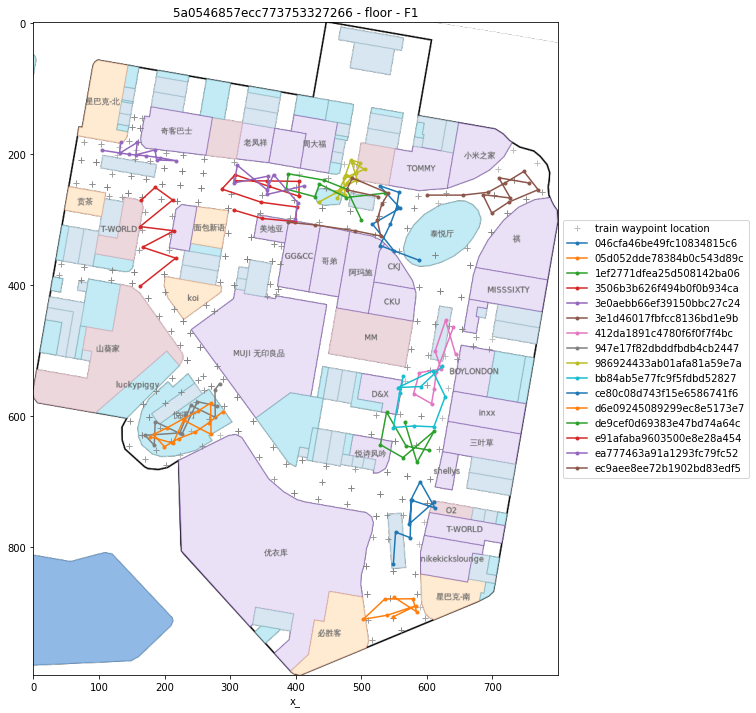

In [80]:
plot_preds(example_site, example_floorNo, sub_df_cm,
           train_waypoints, show_preds=True)

(<Figure size 864x864 with 1 Axes>,
 <AxesSubplot:title={'center':'5a0546857ecc773753327266 - floor - F1'}, xlabel='x_'>)

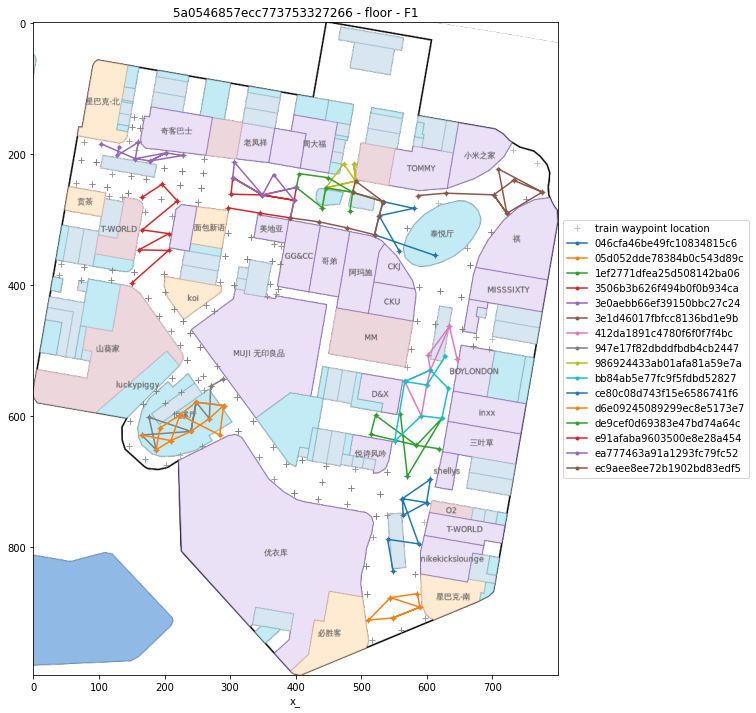

In [81]:
plot_preds(example_site, example_floorNo, sub_pp,
           train_waypoints, show_preds=True)